In [1]:
# iPython extension to autoreload modules when changes are made without restarting kernel
%load_ext autoreload
%autoreload 2

In [78]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Create Environment and Set up Simulation 

In [2]:
from functions.simulation_setup import set_schema_buildings, set_active_observations, set_schema_simulation_period
from citylearn.data import DataSet


print('All CityLearn datasets:', sorted(DataSet().get_dataset_names()))
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet().get_schema(DATASET_NAME)

RANDOM_SEED = 0
BUILDING_COUNT = 2
DAY_COUNT = 7
# ACTIVE_OBSERVATIONS = ['hour', 'month']
ACTIVE_OBSERVATIONS = ['hour', 'month', 'electrical_storage_soc','outdoor_dry_bulb_temperature', 'electricity_pricing', 'solar_generation']

schema, buildings = set_schema_buildings(schema, BUILDING_COUNT, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, DAY_COUNT, RANDOM_SEED)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)
schema['central_agent'] = True


print('Selected buildings:', buildings)
print(
    f'Selected {DAY_COUNT}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', ACTIVE_OBSERVATIONS)


All CityLearn datasets: ['baeda_3dem', 'ca_alameda_county_neighborhood', 'citylearn_challenge_2020_climate_zone_1', 'citylearn_challenge_2020_climate_zone_2', 'citylearn_challenge_2020_climate_zone_3', 'citylearn_challenge_2020_climate_zone_4', 'citylearn_challenge_2021', 'citylearn_challenge_2022_phase_1', 'citylearn_challenge_2022_phase_2', 'citylearn_challenge_2022_phase_3', 'citylearn_challenge_2022_phase_all', 'citylearn_challenge_2022_phase_all_plus_evs', 'citylearn_challenge_2023_phase_1', 'citylearn_challenge_2023_phase_2_local_evaluation', 'citylearn_challenge_2023_phase_2_online_evaluation_1', 'citylearn_challenge_2023_phase_2_online_evaluation_2', 'citylearn_challenge_2023_phase_2_online_evaluation_3', 'citylearn_challenge_2023_phase_3_1', 'citylearn_challenge_2023_phase_3_2', 'citylearn_challenge_2023_phase_3_3', 'quebec_neighborhood_with_demand_response_set_points', 'quebec_neighborhood_without_demand_response_set_points', 'tx_travis_county_neighborhood', 'vt_chittenden_co

## Base Agent

In [3]:
from agents.baseagent import Agent, BaselineAgent
from citylearn.citylearn import CityLearnEnv

base_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
base_agent = BaselineAgent(base_env, random_seed=RANDOM_SEED)

# Initialize Environment
observations, _ = base_env.reset()

while not base_env.terminated:
    actions = base_agent.predict(observations)
    observations, reward, info, terminated, truncated = base_env.step(actions)

# test
kpis = base_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')


Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
# A general environment with discrete observations and actions that can be re-used for multiple agent types
from functions.wrappers import DiscreteAlgorithmWrapper

discrete_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
# Very Large bins and low multiplier for testing purposes

# define active observations and actions and their bin sizes
observation_bins = {'hour':4, 'month':4, 'electrical_storage_soc':3,'outdoor_dry_bulb_temperature':5, 'electricity_pricing':3, 'solar_generation':3}
# observation_bins = {'hour':24, 'month':12}
action_bins = {'electrical_storage': 4}

# Timesteps of simulation per possible state-action pair when simulating
# Higher for more computationally intensive, more thorough simulations
execution_multiplier = 3

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in discrete_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

unwrapped_env = DiscreteAlgorithmWrapper(
    discrete_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)
m = unwrapped_env.observation_space[0].n
n = unwrapped_env.action_space[0].n
t = unwrapped_env.time_steps - 1
num_episodes = min(200, int(m*n*execution_multiplier/t))
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', num_episodes)


Q-Table dimension: (153599, 16)
Number of episodes to train: 200


c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.time_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.time_steps` for environment variables or `env.get_wrapper_attr('time_steps')` that will search the reminding wrappers.
  logger.warn(


# Train Tabular Models
## Q-Learning
Sampling based on CityLearn Implementation to create framework for how we will test and implement our new algorithms

In [35]:
from agents.q_learning import QLearning
from IPython.display import display

# This made for Tabular Q learning, but I think it applies to any discrete algorithm
q_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
q_env = DiscreteAlgorithmWrapper(
    q_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

q_kwargs = {
    'epsilon': 1.0,
    'epsilon_decay': True,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

q_agent = QLearning(
    env=q_env,
    random_seed=RANDOM_SEED,
    **q_kwargs
)

# ----------------- Train -----------------
_ = q_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = q_env.reset()

while not q_env.terminated:
    actions = q_agent.predict(observations, True)
    observations, reward, info, terminated, truncated = q_env.step(actions)

kpis = q_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 200/200 [03:02<00:00,  1.10it/s]
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_Fi

name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,1.882
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,1.368,1.783,1.575
cost_total,1.276,1.619,1.447
daily_one_minus_load_factor_average,NaN,NaN,0.949
daily_peak_average,NaN,NaN,1.880
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


## SARSA Model

In [36]:
from agents.sarsa import Sarsa

sarsa_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
sarsa_env = DiscreteAlgorithmWrapper(
    sarsa_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

sarsa_kwargs = {
    'epsilon': 0.1,
    'alpha': 0.005,
    'gamma': 0.99,
}


sarsa_agent = Sarsa(
    env=sarsa_env,
    random_seed=RANDOM_SEED,
    **sarsa_kwargs
)
# ----------------- Train -----------------
_ = sarsa_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sarsa_env.reset()

while not sarsa_env.terminated:
    actions = sarsa_agent.predict(observations, True)
    observations, reward, info, terminated, truncated = sarsa_env.step(actions)

kpis = sarsa_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymn

name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,1.984
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,1.279,2.029,1.654
cost_total,1.304,2.190,1.747
daily_one_minus_load_factor_average,NaN,NaN,0.957
daily_peak_average,NaN,NaN,1.993
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


# Train Function Approximation Models
## Soft-Actor Critic

In [37]:
from agents.sac import SAC
from citylearn.wrappers import NormalizedSpaceWrapper

# num_episodes = 10
sac_env = CityLearnEnv(schema, random_seed=RANDOM_SEED, central_agent=False)
# sac_env = NormalizedSpaceWrapper(sac_env)

sac_kwargs = {
    'mini_batch_size':256,
    'tau': 0.005,
    'gamma': 0.99,
}


sac_agent = SAC(
    env=sac_env,
    random_seed=RANDOM_SEED,
    **sac_kwargs
)
# ----------------- Train -----------------
_ = sac_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sac_env.reset()
sac_actions = []
while not sac_env.terminated:
    actions = sac_agent.predict(observations, deterministic=True)
    observations, reward, info, terminated, truncated = sac_env.step(actions)
    sac_actions.append(actions)

kpis = sac_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

  0%|          | 0/200 [00:00<?, ?it/s]/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/agents/sac.py:114: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  actions = torch.FloatTensor(actions, device=self.device)
100%|██████████| 200/200 [10:06<00:00,  3.03s/it]


name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,1.000
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,0.710,0.994,0.852
cost_total,0.707,0.982,0.844
daily_one_minus_load_factor_average,NaN,NaN,0.974
daily_peak_average,NaN,NaN,0.950
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


## MADDPG with Custom Reward Function

In [ ]:
from agents.maddpg import MADDPGAgent, ReplayBuffer
import numpy as np
from tqdm import tqdm
from functions.reward_function import ReducedCostReward

# set up environment as 1 agent per building
schema['central_agent'] = False
MADDPG_env = CityLearnEnv(schema, random_seed=RANDOM_SEED, reward_function=ReducedCostReward)
obs = MADDPG_env.reset()
print(observations)

# set up parameters for agent and replay buffer
steps_per_episode = MADDPG_env.episode_time_steps
num_agents = len(MADDPG_env.buildings)
obs_dim = len(obs[0][0])
act_dim = MADDPG_env.action_space[0].shape[0]
device = 'cpu'

print(obs_dim, act_dim)
print(len(MADDPG_env.buildings))
print("Active Observations: ", MADDPG_env.observation_names)
print("Active Actions: ", MADDPG_env.action_names)

MADDPG_agent = MADDPGAgent(num_agents=num_agents, 
                           obs_dim=obs_dim, 
                           act_dim=act_dim,
                           device='cpu')

replay_buffer = ReplayBuffer(obs_dim=obs_dim, 
                             act_dim=act_dim,
                             num_agents=num_agents, 
                             device='cpu')

# ----------------- Train -----------------
for ep in tqdm(range(num_episodes)):
    obs, _ = MADDPG_env.reset()
    total_reward = 0.0
    for t in range(steps_per_episode):
        # Select actions with exploration
        action = MADDPG_agent.select_action(obs)

        # Step environment
        next_obs, rewards, done, *_ = MADDPG_env.step(action)

        # If rewards is a scalar or single value, broadcast to all agents
        if np.isscalar(rewards):
            rewards = np.array([rewards]*num_agents)

        # Store the transition
        replay_buffer.store(np.array(obs), np.array(action), rewards, np.array(next_obs), np.array([done]))

        # Update the agent (assuming enough samples)
        MADDPG_agent.update(replay_buffer)

        obs = next_obs
        total_reward += sum(rewards)

        if done:
            break

# ----------------- Test -----------------
# Initialize Environment
MADDPG_agent.noise_std = 0
observations, _ = MADDPG_env.reset()
done = False
mad_actions = []
while not done:
    actions = MADDPG_agent.select_action(observations)
    observations, reward, done, *_ = MADDPG_env.step(actions)

    mad_actions.append(actions)

kpis = MADDPG_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

[[6, 23, 16.1, 0.0, 0.0, 0.22, 0.0, 0.0]]
6 1
2
Active Observations:  [['month', 'hour', 'outdoor_dry_bulb_temperature', 'solar_generation', 'electrical_storage_soc', 'electricity_pricing'], ['month', 'hour', 'outdoor_dry_bulb_temperature', 'solar_generation', 'electrical_storage_soc', 'electricity_pricing']]
Active Actions:  [['electrical_storage'], ['electrical_storage']]


100%|██████████| 200/200 [12:24<00:00,  3.72s/it]


name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,1.849
annual_normalized_unserved_energy_total,0.000,0.0,0.000
carbon_emissions_total,1.078,1.0,1.039
cost_total,1.079,1.0,1.039
daily_one_minus_load_factor_average,NaN,NaN,0.995
daily_peak_average,NaN,NaN,1.192
discomfort_cold_delta_average,0.000,0.0,0.000
discomfort_cold_delta_maximum,0.000,0.0,0.000
discomfort_cold_delta_minimum,0.000,0.0,0.000


# Plot Performance

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


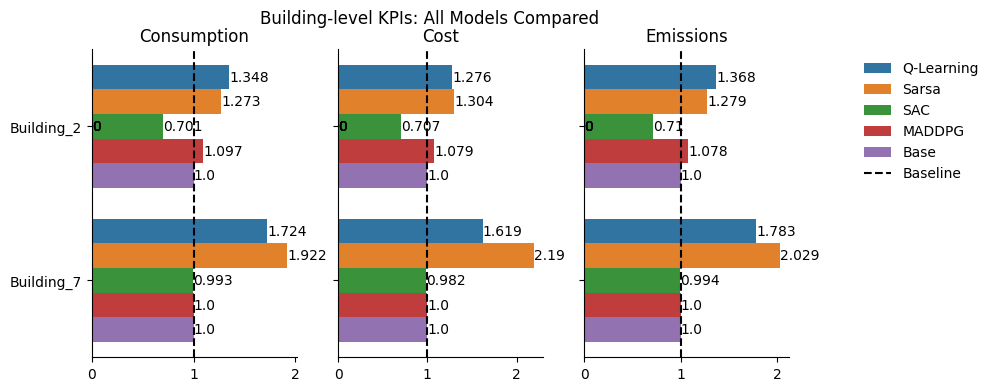

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


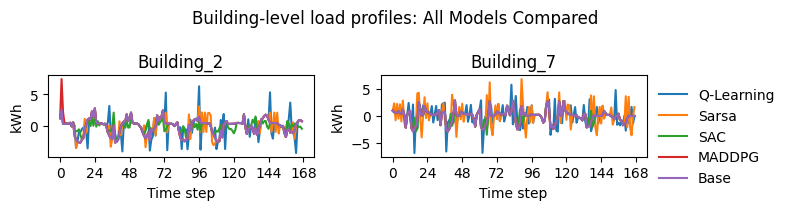

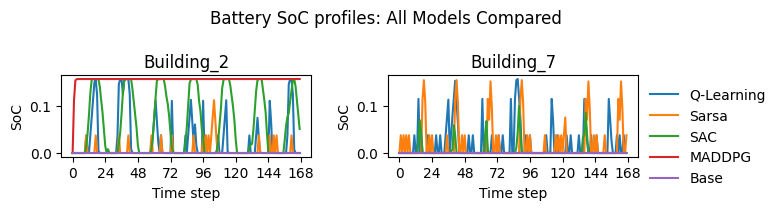

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


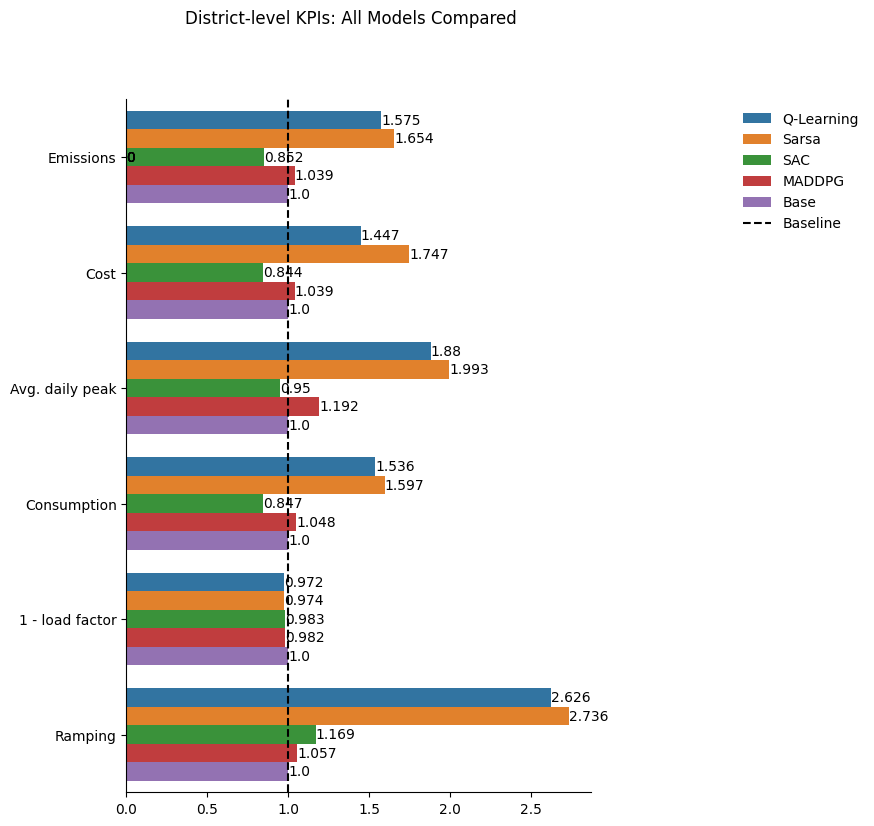

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.net_electricity_consumption to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption` for environment variables or `env.get_wrapper_attr('net_electricity_consumption')` that will search the reminding wrappers.
  logger.warn(


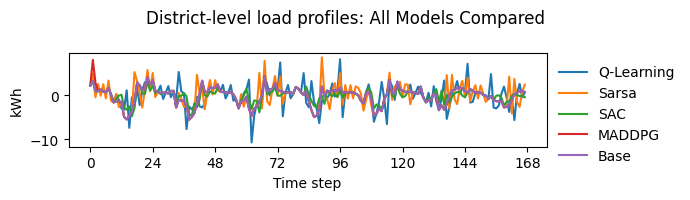

In [39]:
from functions.make_figures import plot_simulation_summary

plot_simulation_summary({'Q-Learning':q_env, 
                         'Sarsa': sarsa_env, 
                         'SAC':sac_env, 
                         'MADDPG':MADDPG_env, 
                         'Base': base_env},
                         "All Models Compared")

# Compare Tabular Models to Baseline

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


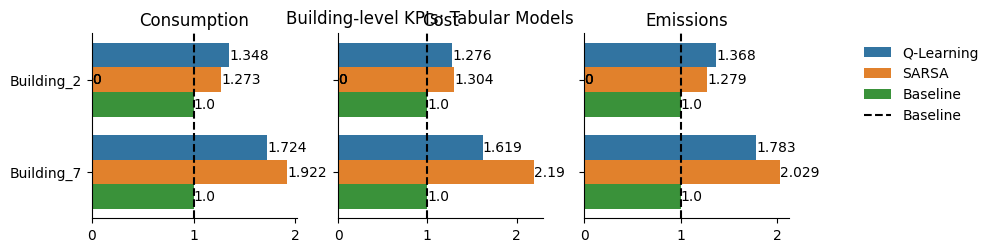

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


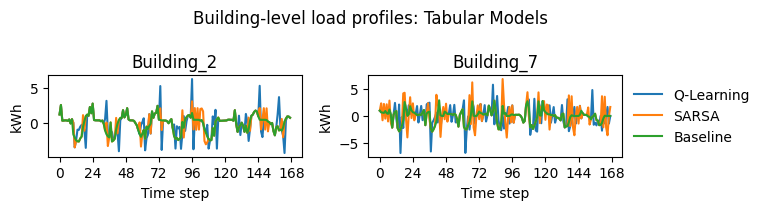

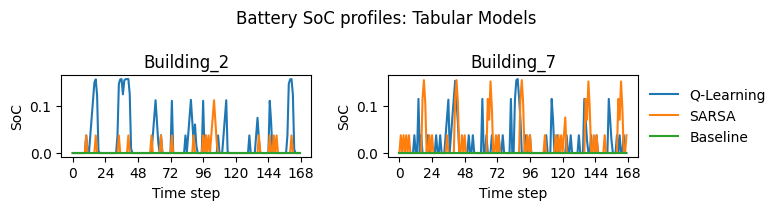

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


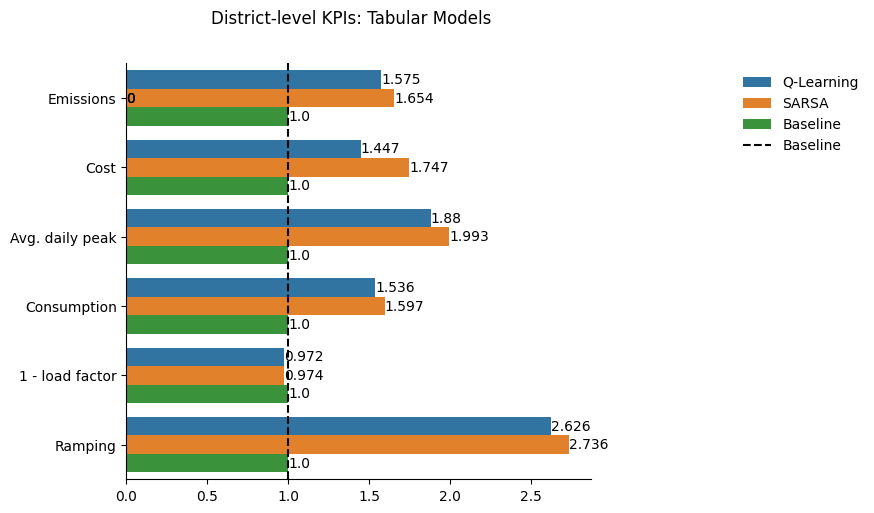

/home/casey/Documents/Graduate_School/24_Fall/CS138/Fa24-CS-138-_FinalProject/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.net_electricity_consumption to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption` for environment variables or `env.get_wrapper_attr('net_electricity_consumption')` that will search the reminding wrappers.
  logger.warn(


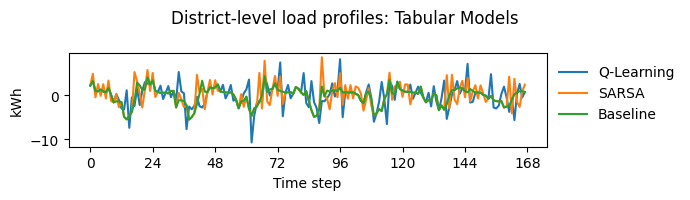

In [40]:
plot_simulation_summary({'Q-Learning':q_env, 
                         'SARSA':sarsa_env, 
                         'Baseline':base_env}, 
                         'Tabular Models')

# Compare Approximation Models to Baseline

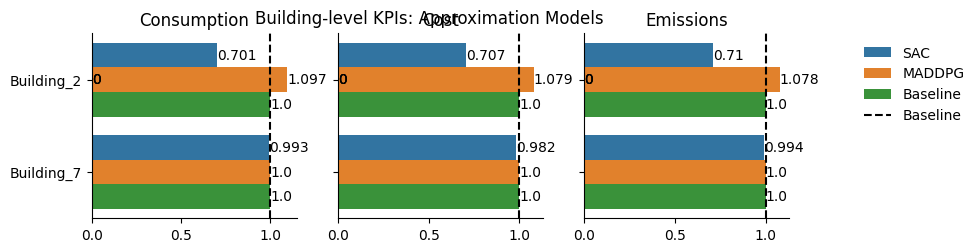

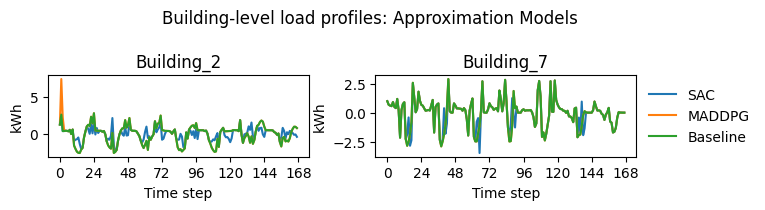

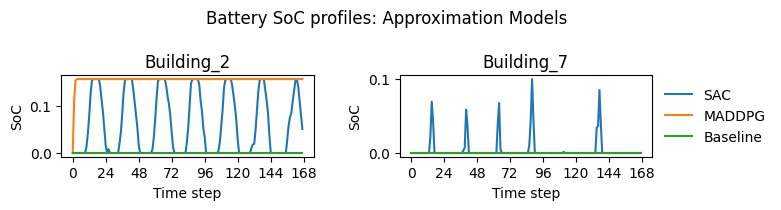

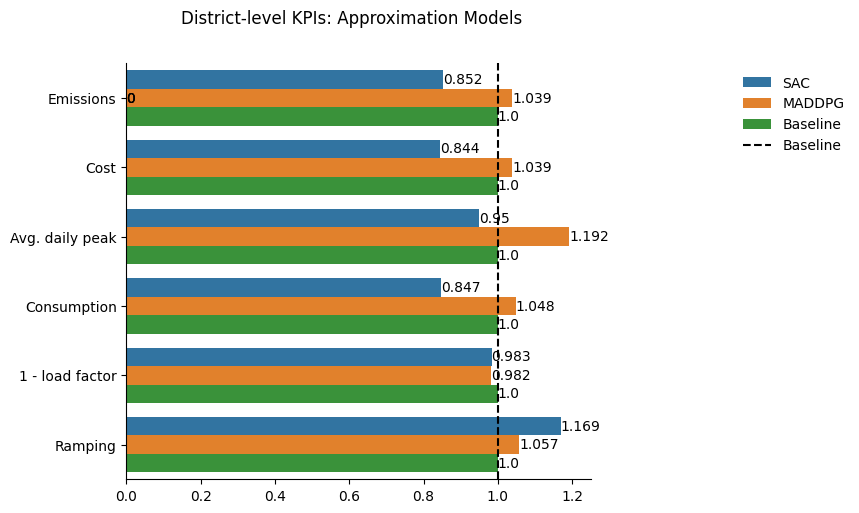

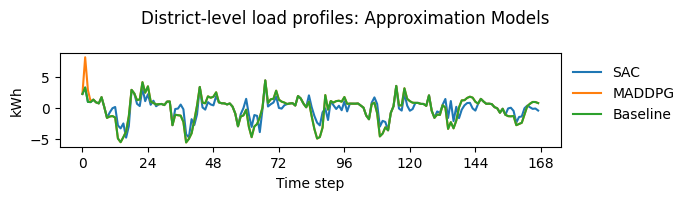

In [41]:
plot_simulation_summary({'SAC': sac_env,
                         'MADDPG': MADDPG_env,
                         'Baseline': base_env
                         },
                         'Approximation Models')

## Plot SAC actions averaged over 24 hours to average electricity pricing and solar generation

In [5]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet().get_schema(DATASET_NAME)

RANDOM_SEED = 0
BUILDING_COUNT = 2
DAY_COUNT = 7
# ACTIVE_OBSERVATIONS = ['hour', 'month']
ACTIVE_OBSERVATIONS = ['hour', 'electrical_storage_soc','outdoor_dry_bulb_temperature', 'electricity_pricing', 'solar_generation']

schema, buildings = set_schema_buildings(schema, BUILDING_COUNT, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, DAY_COUNT, RANDOM_SEED)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)
schema['central_agent'] = True


print('Selected buildings:', buildings)
print(
    f'Selected {DAY_COUNT}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Selected buildings: ['Building_2', 'Building_7']
Selected 7-day period time steps: (7392, 7559)
Active observations: ['hour', 'electrical_storage_soc', 'outdoor_dry_bulb_temperature', 'electricity_pricing', 'solar_generation']


In [7]:
from agents.sac import SAC
from citylearn.wrappers import NormalizedSpaceWrapper

num_episodes = 200
sac_env = CityLearnEnv(schema, random_seed=RANDOM_SEED, central_agent=False)
# sac_env = NormalizedSpaceWrapper(sac_env)

sac_kwargs = {
    'mini_batch_size':256,
    'tau': 0.005,
    'gamma': 0.99,
}


sac_agent = SAC(
    env=sac_env,
    random_seed=RANDOM_SEED,
    **sac_kwargs
)
# ----------------- Train -----------------
_ = sac_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sac_env.reset()
sac_actions = []
while not sac_env.terminated:
    actions = sac_agent.predict(observations, deterministic=True)
    observations, reward, info, terminated, truncated = sac_env.step(actions)
    sac_actions.append(actions)

kpis = sac_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

100%|██████████| 200/200 [11:33<00:00,  3.47s/it]


name,Building_2,Building_7,District
cost_function,,,
all_time_peak_average,NaN,NaN,0.741
annual_normalized_unserved_energy_total,0.000,0.000,0.000
carbon_emissions_total,0.811,0.865,0.838
cost_total,0.781,0.780,0.781
daily_one_minus_load_factor_average,NaN,NaN,0.977
daily_peak_average,NaN,NaN,0.856
discomfort_cold_delta_average,0.000,0.000,0.000
discomfort_cold_delta_maximum,0.000,0.000,0.000
discomfort_cold_delta_minimum,0.000,0.000,0.000


In [112]:
def retrieve_data(schema, building_name, datafile):
    root_directory = schema['root_directory']
    filename = schema['buildings'][building_name][datafile]
    filepath = os.path.join(root_directory, filename)
    return pd.read_csv(filepath)

pricing_data = []
solar_data = []
load_data = []

for building in buildings:
    pricing = retrieve_data(schema, building, 'pricing')
    solar = retrieve_data(schema, building, 'energy_simulation')
    
    pricing_np = pricing.iloc[simulation_start_time_step : simulation_end_time_step + 1].groupby(by=lambda a: (a - 1) % 24 + 1).mean().loc[:,'electricity_pricing'].to_numpy()
    solar_np = solar.iloc[simulation_start_time_step : simulation_end_time_step + 1].groupby('hour').mean().loc[:,'solar_generation'].to_numpy()
    load_np = solar.iloc[simulation_start_time_step : simulation_end_time_step + 1].groupby('hour').mean().loc[:,'non_shiftable_load'].to_numpy()

    pricing_data.append(pricing_np)
    solar_data.append(solar_np)
    load_data.append(load_np)

In [113]:
actions = [list(map(lambda a: a[0], building)) for building in zip(*sac_actions)]
avg_actions = []

for actions_list in actions:
    actions_list.append(np.nan)
    daily_actions = np.array(actions_list).reshape(DAY_COUNT, 24)
    avg_actions.append(np.nanmean(daily_actions, axis = 0))

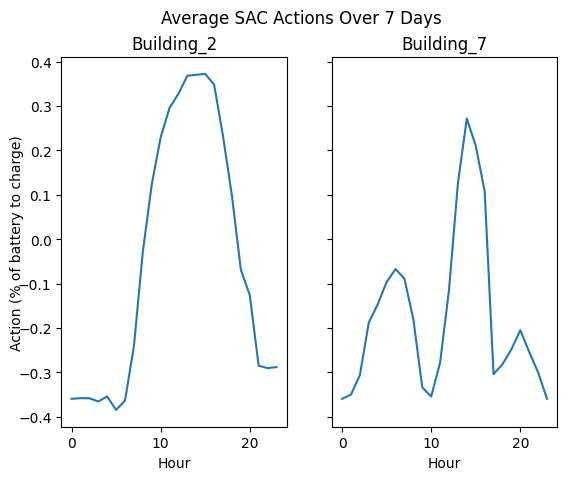

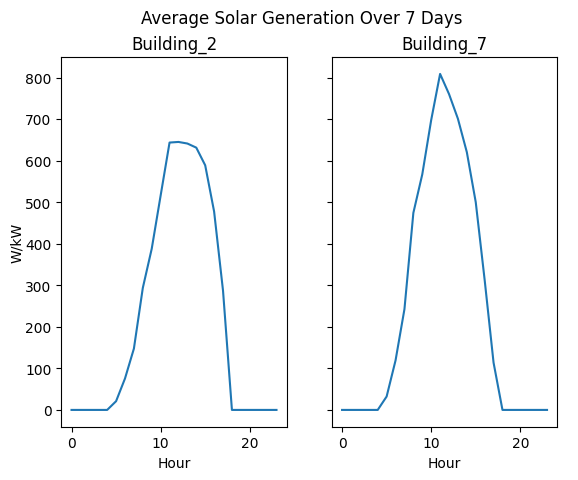

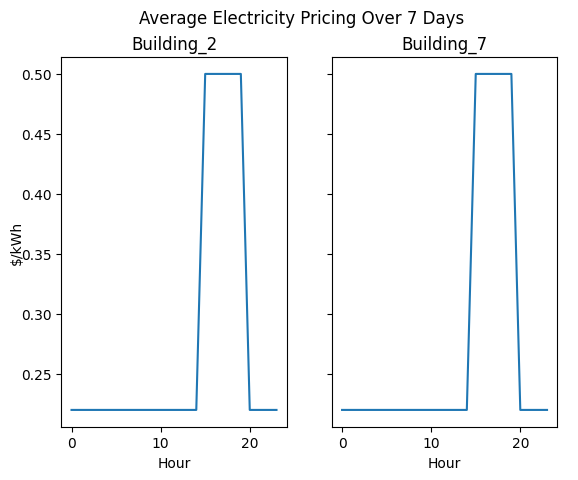

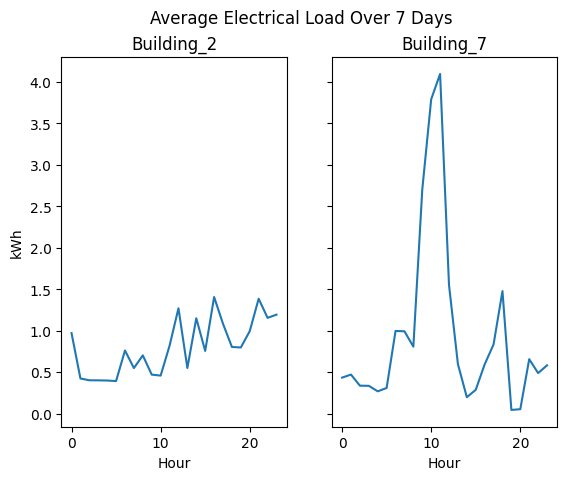

In [114]:
# plot actions
fig, _ = plt.subplots(1, 2, sharey=True)

for i, ax in enumerate(fig.axes):
    ax.plot(avg_actions[i])
    ax.set_title(buildings[i])
    ax.set_xlabel('Hour')


fig.suptitle("Average SAC Actions Over 7 Days")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Action (% of battery to charge)")
plt.show()

# plot solar generation
fig, _ = plt.subplots(1, 2, sharey=True)

for i, ax in enumerate(fig.axes):
    ax.plot(solar_data[i])
    ax.set_title(buildings[i])
    ax.set_xlabel('Hour')


fig.suptitle("Average Solar Generation Over 7 Days")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("W/kW")
plt.show()


# plot electric pricing
fig, _ = plt.subplots(1, 2, sharey=True)

for i, ax in enumerate(fig.axes):
    ax.plot(pricing_data[i])
    ax.set_title(buildings[i])
    ax.set_xlabel('Hour')


fig.suptitle("Average Electricity Pricing Over 7 Days")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("$/kWh")
plt.show()

# plot load
fig, _ = plt.subplots(1, 2, sharey=True)

for i, ax in enumerate(fig.axes):
    ax.plot(load_data[i])
    ax.set_title(buildings[i])
    ax.set_xlabel('Hour')


fig.suptitle("Average Electrical Load Over 7 Days")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("kWh")
plt.show()



In [20]:
root_directory = schema['root_directory']
building_name = 'Building_2'
filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
data = pd.read_csv(filepath)
display(data.iloc[simulation_start_time_step:simulation_end_time_step + 1,:].columns)

Index(['month', 'hour', 'day_type', 'daylight_savings_status',
       'indoor_dry_bulb_temperature',
       'average_unmet_cooling_setpoint_difference', 'indoor_relative_humidity',
       'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand',
       'solar_generation'],
      dtype='object')